In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

This is a 2D modelisation of the heat transfert. The equation used is known as the heat equation :
$$ \dfrac{\partial T}{\partial t} - \alpha ( \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} ) = 0
$$
Alpha is the diffusion coefficient.

First, we define some functions to create an initial temperature matrix (or map) T0.

Then we use the function **diffuse** that implement a descretization of the heat transfert problem.
This function takes an matrix T0 and compute the temperature matrix T after a certain time.

Finally we define some functions that serve the purpose of saving a great number of T0 and T maps as images.

The data generated with these functions can be uploaded to a machine learning script through a torch.Dataset object
by using the module **customDataset.py**

NB : for physics purist, the spatial and time parameters have all been rigorously defines
with units specified in the function **diffuse**.
Nonetheless the initial matrices set temperatures between 0 and 1 and thus need to be scaled to the desired physical values. \\

# Initialisation : T0 matrices
(heat_diffusion_simul.py)

In [ ]:
#@markdown Defining functions that create np.arrays  "T0"
def T0blocksMap(nx,ny):
    """
    Create a numpy.array of size ny,nx composed of 16 blocks (ny/4, nx/4) of all zeros or all ones randomly.
    (according to uniform law)
    """
    matrix = np.zeros((ny, nx))

    # Divide the matrix into 16 squares
    squares = np.split(matrix, 4, axis=0)
    squares = [np.split(square, 4, axis=1) for square in squares]

    # Randomly assign values to each square
    for row in range(4):
        for col in range(4):
            value = np.random.randint(2)
            squares[row][col][:, :] = value

    # Flatten the list of squares and return the matrix
    matrix = np.concatenate([np.concatenate(row, axis=1) for row in squares], axis=0)

    return matrix

def T0blocksMapV2(nx,ny):
    """
    Create a numpy.array of size ny,nx composed of blocks of all zeros or all ones randomly (according to uniform law).
    The size of the blocks are random too.
    """
    matrix = np.zeros((ny, nx))

    # Randomly choose split points for rows and columns
    row_split_points = np.sort(np.random.choice(range(1, ny), size=3, replace=False))
    col_split_points = np.sort(np.random.choice(range(1, nx), size=3, replace=False))

    # Divide the matrix into squares based on split points
    squares = np.split(matrix, row_split_points, axis=0)
    squares = [np.split(square, col_split_points, axis=1) for square in squares]

    # Randomly assign values to each square
    for row in range(4):
        for col in range(4):
            value = np.random.randint(2)
            squares[row][col][:, :] = value

    # Flatten the list of squares and return the matrix
    matrix = np.concatenate([np.concatenate(row, axis=1) for row in squares], axis=0)
    return matrix

def T0sinusMap(nx,ny):
    """
    Create a numpy.array of size ny,nx composed of values between 0 and 1
    following a sinus-like distribution along both axis.
    The sinus are randoms
    """
    x, y = np.meshgrid(np.linspace(0, 1, ny), np.linspace(0, 1, nx))
    a = np.random.normal()
    b = np.random.normal()
    matrix = np.sin(a*2*np.pi*x) * np.sin(b*2*np.pi*y) + np.random.normal(scale=0.05, size=(ny, nx))
    matrix = np.clip(matrix, 0, 1)
    return matrix

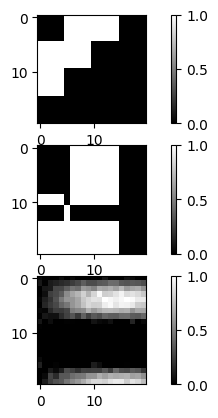

In [ ]:
test1 = T0blocksMap(20,20)
test2 = T0blocksMapV2(20,20)
test3 = T0sinusMap(20,20)

plt.figure()
plt.subplot(3,1,1)
plt.imshow(test1, cmap='gray', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(test2, cmap='gray', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(test3, cmap='gray', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

# Heat equation, discrete implementation
(heat_diffusion_simul.py) \\

$$ \dfrac{\partial T}{\partial t} - \alpha ( \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} ) = 0 
\\ \Leftrightarrow \partial T = \alpha dt( \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} )
\\ \Leftrightarrow T(t+dt) = T(t) + \alpha dt( \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} )
\\ besides : \dfrac{\partial T}{\partial x} = \frac{T(x+dx/2)-T(x-dx/2)}{dx}
\\ finally : T(t+dt) = T(t) + \frac{\alpha dt}{dx^2}[T(x+dx)+T(x-dx)+T(y+dy)-T(y-dy)-4T(x,y)]
$$

In [ ]:
#@markdown Defining the function that take T0 as input and output T at a given time
def diffuse(T_matrix, iterations, dt, dx, coef_diff):
    """
    Takes a map of temperature as input and return a new map where temperature has evolve during a time step*dt.

    Discretisation of the heat diffusion equation in 2D :
    Temperature = T(x,y,t)
    diff(T, t) = alpha * [ diff2(T, x) + diff2(T, y)] = 0
        --> T(t+dt) = T(t) + [alpha*dt/(dx)**2] * [ T(x+dx)+T(x-dx) + T(y+dy)+T(y-dy) - 4*T(x,y) ]

    :param T_matrix: temperature map at t initial (t_i)
    :param iterations: number of steps to evolve the temperature map
    :param dt : duration of one iteration in second
    :param dx : size of the spatial discretization in meter(dy is the same)
    :param coef_diff : diffusivité thermique m2.s-1

    :return: the new temperature map at t = t_i + iterations*dt
    """

    T = T_matrix.copy()
    ny,nx = T.shape #convention x is number of columns to fit with a basic plot (x,y)  (in fact -y cause matrices display)
    coef = coef_diff * dt / (dx * dx)
    for _ in range(iterations):
        for i in range(1,ny-1):
            for j in range(1,nx-1):
                T[i,j] = T[i,j] + coef * (T[i+1,j]+T[i-1,j]+T[i,j+1]+T[i,j-1]-4*T[i,j])
            # Edges
            T[i, 0] = T[i,0] + coef * (T[i+1,0]+T[i-1,0]+T[i,1]+T[i,0]-4*T[i,0])
            T[i, nx-1] = T[i,nx-1] + coef * (T[i+1,nx-1]+T[i-1,nx-1]+T[i,nx-1]+T[i,nx-2]-4*T[i,nx-1])
        for j in range(1,nx-1):
            T[0, j] = T[0,j] + coef * (T[1,j]+T[0,j]+T[0,j+1]+T[0,j-1]-4*T[0,j])
            T[ny-1, j] = T[ny-1,j] + coef * (T[ny-1,j]+T[ny-2,j]+T[ny-1,j+1]+T[ny-1,j-1]-4*T[ny-1,j])

        # Corners
        T[0, 0] = T[0,0] + coef * (T[1,0]+T[0,0]+T[0,1]+T[0,0]-4*T[0,0])
        T[0, nx-1] = T[0,nx-1] + coef * (T[1,nx-1]+T[0,nx-1]+T[0,nx-1]+T[0,nx-2]-4*T[0,nx-1])
        T[ny-1, 0] = T[ny-1,0] + coef * (T[ny-1,0]+T[ny-2,0]+T[ny-1,1]+T[ny-1,0]-4*T[ny-1,0])
        T[ny-1, nx-1] = T[ny-1,nx-1] + coef * (T[ny-1,nx-1]+T[ny-2,nx-1]+T[ny-1,nx-1]+T[ny-1,nx-2]-4*T[ny-1,nx-1])

    return T

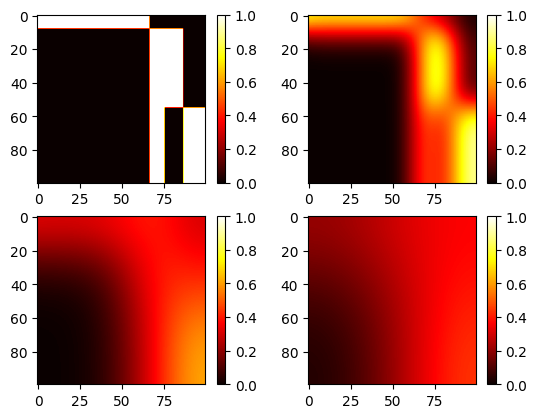

In [ ]:
# Define parameters
pixels = 100 # Number of grid points in each direction

# all the following is just a scaling of the coef of diffusion nothing more
# the discretization time however appears in the diffusion coef too but also on the nb of iteration (precision)
size = 1 #in meter
spatial_step = size/pixels #spatial discretization step in meter
alpha = 0.003 # Diffusion coefficient

t1 = .5 # Total time
time_step = 0.01 # Time discretization step in sec
N = int(t1 / time_step) # Number of time steps

# Initialize grid
u0 = T0blocksMapV2(pixels,pixels)

#make 3 matrices of diffusion.
u1 = diffuse(u0, N, time_step, spatial_step, alpha)
u2 = diffuse(u1, 5*N, time_step, spatial_step, alpha)
u3 = diffuse(u2, 10*N, time_step, spatial_step, alpha)


plt.figure()
plt.subplot(2,2,1)
plt.imshow(u0, cmap='hot', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(u1, cmap='hot', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(u2, cmap='hot', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(u3, cmap='hot', origin='upper', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

# Data generation
(heat_diffusion_simul.py)

In [ ]:
def generate_data(n_samples, T0_func, n=100, iters=(10,40,50), coef_diffusion=0.003, dx=0.01, dt=0.01):
    """
    Create n_samples T0 matrices.
    For each of these, apply the function "diffuse" for the number of iterations specified.
    Save the results in the following path after cwd :
        data/{coef_diffusion}/{T0_func}/iteration_no0/ for the T0 matrices (T initial)
        data/{coef_diffusion}/{T0_func}/iteration_noN/ for the TN matrices (T0 after N iterations of the diffusion)

        samples are named nosample.png

    :param n_samples: number of samples wanted
    :param T0_func: func to use for creation of T0
    :param n: nb of row and cols of the matrices
    :param iters: if type int : nb of iterations to apply on T0 before saving the result.
                  if type list/tupple : T1 = diffusion of T0 during iters[0] time steps
                                        T2 = diffusion of T1 during iters[1] time steps
                                        ...and so on
                                in this case iters=(5,10,15) will produce the images for iteration_no0, no5, no15, no30
    :param coef_diffusion: coef alpha in heat equation in m^2.s^-1
    :param dx: spatial discretization step (horizontal and vertical is the same) in meter
    :param dt: temporal discretization step (duration of one iteration step) in second
    :return: None

    N.B. load the data with customDataset.HeatDiffusion
    """
    #could change iters into times but create an error intrinsic to the modelisation
    #not good to check performances of the nn later, or we should quantizize this error

    if type(iters) == int:
        iters = [iters]

    import os
    data_folder = f"data/{str(coef_diffusion).replace('.','_')}/{T0_func.__name__}"
    while os.path.exists(data_folder):
        data_folder += "(1)"
    os.makedirs(data_folder)

    cummulative_iters = [0] + list(iters)
    os.makedirs(data_folder + f'/iteration_no{str(0)}')
    for i in range(1,len(cummulative_iters)):
        cummulative_iters[i]+=cummulative_iters[i-1]
        os.makedirs(data_folder+f'/iteration_no{str(cummulative_iters[i])}')

    for s in tqdm(range(n_samples)):
        T = T0_func(n,n)
        current_iter = 0
        plt.imsave(data_folder + f'/iteration_no{str(current_iter)}/{str(s)}.png', T, vmin=0.0, vmax=1.0, cmap='gray')
        for it in iters:
            T = diffuse(T, it, dt, dx, coef_diffusion)
            current_iter += it
            plt.imsave(data_folder+f'/iteration_no{str(current_iter)}/{str(s)}.png', T, vmin=0.0, vmax=1.0, cmap='gray')
    return None

In [ ]:
generate_data(10, T0blocksMap)

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


In [ ]:
def generate_data2(n_samples, n=100, iters=(10,40,50), coef_diffusion=0.003, dx=0.01, dt=0.01):
    """
    Same as "generate_data" except we do not choose T0_func, it is set as a mix of T0blocksMapV2 and T0sinusMap
    """
    import os
    data_folder = f"data/{str(coef_diffusion).replace('.','_')}/ALLMAPS"
    while os.path.exists(data_folder):
        data_folder += "(1)"
    os.makedirs(data_folder)

    cummulative_iters = [0] + list(iters)
    os.makedirs(data_folder + f'/iteration_no{str(0)}')
    for i in range(1,len(cummulative_iters)):
        cummulative_iters[i]+=cummulative_iters[i-1]
        os.makedirs(data_folder+f'/iteration_no{str(cummulative_iters[i])}')

    MAPS = [T0blocksMapV2, T0sinusMap]
    for s in tqdm(range(n_samples)):
        T = MAPS[s%2](n,n)
        current_iter = 0
        plt.imsave(data_folder + f'/iteration_no{str(current_iter)}/{str(s)}.png', T, vmin=0.0, vmax=1.0, cmap='gray')
        for it in iters:
            T = diffuse(T, it, dt, dx, coef_diffusion)
            current_iter += it
            plt.imsave(data_folder+f'/iteration_no{str(current_iter)}/{str(s)}.png', T, vmin=0.0, vmax=1.0, cmap='gray')
    return None

In [ ]:
generate_data2(10, coef_diffusion=0.002)

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


In [ ]:
def generate_data_multialpha(n_samples_per_alpha=20, T0_func=T0blocksMap, n=100, it=10, coefs_diffusion=(0.003,), dx=0.01, dt=0.01):
    """
    Create (samples_per_alpha*len(coefs_diffusion)) T0 matrices.
    For each of these, apply the function "diffuse" for the number of iterations specified.
    Save the results in the following path after cwd :
        data/{T0_func}/iteration_no0/ for the T0 matrices (T initial)
        data/{T0_func}/iteration_noN/ for the TN matrices (T0 after N iterations of the diffusion)

        samples are named {decimals_of_alpha}_nosample.png

    :param n_samples_per_alpha: number of samples wanted for each value of alpha (diffusion coef)
    :param T0_func: func to use for creation of T0
    :param n: nb of row and cols of the matrices
    :param it: type int, nb of iterations to apply on T0 before saving the result.
        (does not currently support iters as a list converselly to 'generate_data')
    :param coefs_diffusion: coefs alpha in heat equation in m^2.s^-1
        type : list, the dataset will contains n samples per alpha, all mixed
    :param dx: spatial discretization step (horizontal and vertical is the same) in meter
    :param dt: temporal discretization step (duration of one iteration step) in second
    :return: None

    N.B. load the data with customDataset.HeatDiffusion_multialpha
    """
    coefs_diffusion = list(coefs_diffusion)

    import os
    data_folder = f"data/{T0_func.__name__}"
    while os.path.exists(data_folder):
        data_folder += "(1)"

    os.makedirs(data_folder + f"/iteration_no0")
    os.makedirs(data_folder + f"/iteration_no{str(it)}")

    for i in tqdm(range(len(coefs_diffusion))):
        for s in range(n_samples_per_alpha):

            T = T0_func(n,n)
            plt.imsave(data_folder + f"/iteration_no0/{str(coefs_diffusion[i]).replace('.', '')}_{str(s)}.png", T, vmin=0.0, vmax=1.0, cmap='gray')
            T = diffuse(T, it, dt, dx, coefs_diffusion[i])
            plt.imsave(data_folder + f"/iteration_no{it}/{str(coefs_diffusion[i]).replace('.', '')}_{str(s)}.png", T, vmin=0.0, vmax=1.0, cmap='gray')
    return None


In [ ]:
alphas = [0.0005 * i for i in range(1,9)]
generate_data_multialpha(5, coefs_diffusion=alphas)

100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


(google collab)
After running all these codes you can check on the left pannel (icon "folder") that the data has been saved in content/data/ \\
Depending on the generate function used, the directories trees are different so make sure you understand how they are structured.

# Defining custom Datasets
(customDataset.py) \\
 \\
Here we define classes to create a torch Dataset from the data generated by the previous generation functions. \\
 \\

**HeatDiffusion** is the class to use in order to load the data of 'generate_data'

**HeatDiffusion_multi_alpha** is to be use for data of 'generate_data_multialpha'

**HeatDiffusion_multi_outputs** is to be use for any data in the case where we want the neural network to have multiple outputs and be trained on every one of them.
        See : RNN_heat.py and NODE_heat_multi_train.py \\
 \\

NB :
An element of a TrainLoader used with each kind of datasets has following format and types : \\

HeatDiffusion: list( input_images:3Dtensor(batch_size,v_dim,h_dim), output_images:same ) \\
HeatDiffusion_multi_alpha : list( list(input_images:3Dtensor, alphas:1Dtensor(batch_size), output_images:3Dtensor ) \\
HeatDiffusion_multi_outputs : list( input_images:3Dtensor,
                                        list( output_images:3Dtensor for len(output_directories) ) )


In [16]:
import os
from torch.utils.data import Dataset
from skimage import io
from numpy import squeeze #it remove [ ] around single values in a matrix

In [17]:
class HeatDiffusion(Dataset):
    """
    HOW TO USE A HeatDiffusion OBJECT :
        from customDataset import HeatDiffusion
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader

        #load data
        input_folder = 'data/0_003/T0blocksMap/iteration_no0'
        output_folder = 'data/0_003/T0blocksMap/iteration_no10'
        dataset = HeatDiffusion(input_folder, output_folder, transform=transforms.ToTensor())

        batch_size = 20 #for instance
        train_set, test_set = torch.utils.data.random_split(dataset, [200,100])
        train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_set, batch_size=batch_size,shuffle=True)
    """
    def __init__(self, input_dir, output_dir, transform=None):
        """
        Create a torch.utils.data.dataset object with images of the diffusion simulation.

        :param input_dir: path of the directory that contains the initial temperature maps (usually */iteration_no0)
        :param output_dir: path of the directory that contains the final temperature maps (usually */iteration_noN)
        :param transform: transformation to use, torchvision.transforms.ToTensor() is neccessary most of the time
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        """returns the nb of samples in the dataset"""
        nb_input = os.listdir(self.input_dir)
        nb_output = os.listdir(self.output_dir)
        if nb_input == nb_output:
            return len(nb_input)
        else:
            print(f"WARNING : there is {nb_output} outputs (labels) for {nb_input} inputs.")

    def __getitem__(self, index):
        """
        :param index: # of the sample we want (the names of the samples in input and output dir should be index.png)
        :return: input_image[index]: tensor(v_dim,h_dim), output_image[index]: tensor(v_dim,h_dim)
        """
        input_image = squeeze(io.imread(self.input_dir+f'/{str(index)}.png')[:,:,0]) #we only want one of the RGB channel
        output_image = squeeze(io.imread(self.output_dir + f'/{str(index)}.png')[:,:,0]) #as the image is grayscaled

        if self.transform:
            input_image = self.transform(input_image)[0] #[0] cause ToTensor() adds a useless dimension
            output_image = self.transform(output_image)[0]

        return input_image, output_image

In [18]:
class HeatDiffusion_multi_alpha(Dataset):
    """
    HOW TO USE A HeatDiffusion OBJECT :
        from customDataset import HeatDiffusion
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader

        #load data
        input_folder = 'data/T0blocksMap/iteration_no0'
        output_folder = 'data/T0blocksMap/iteration_no10'
        dataset = HeatDiffusion(input_folder, output_folder, transform=transforms.ToTensor())

        batch_size = 20 #for instance
        train_set, test_set = torch.utils.data.random_split(dataset, [200,100])
        train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_set, batch_size=batch_size,shuffle=True)
    """
    def __init__(self, input_dir, output_dir, transform=None):
        """
        Create a torch.utils.data.dataset object with images of the diffusion simulation.
        Difference with standard class 'HeatDiffusion':
            do not specify a diffusion_coeficient in the path of input and output images
            samples are a collection of multiple apha coeficients

        :param input_dir: path of the directory that contains the initial temperature maps (usually */iteration_no0)
        :param output_dir: path of the directory that contains the final temperature maps (usually */iteration_noN)
        :param transform: transformation to use, torchvision.transforms.ToTensor() is neccessary most of the time
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        """returns the nb of samples in the dataset"""
        nb_input = os.listdir(self.input_dir)
        nb_output = os.listdir(self.output_dir)
        if nb_input == nb_output:
            return len(nb_input)
        else:
            print(f"WARNING : there is {nb_output} outputs (labels) for {nb_input} inputs.")

    def __getitem__(self, index):
        """
        :param index: # of the sample we want (ascendent order of alpha_coef and then # of the images)
        :return: (input_image[index]: tensor(v_dim,h_dim), alpha used to compute output: float)
                    ,output_image[index]: tensor(v_dim,h_dim)
        """
        alpha = ((index//20)+1)*0.0005
        name = f"{str(alpha).replace('.','')}_{index%20}.png"
        input_image = squeeze(io.imread(self.input_dir +'/'+name)[:,:,0]) #we only want one of the RGB channel
        output_image = squeeze(io.imread(self.output_dir+'/'+name)[:,:,0]) #as the image is grayscaled

        if self.transform:
            input_image = self.transform(input_image)[0] #[0] cause ToTensor() adds a useless dimension
            output_image = self.transform(output_image)[0]

        return (input_image, alpha), output_image

In [19]:
class HeatDiffusion_multi_outputs(Dataset):
    """
    HOW TO USE A HeatDiffusion OBJECT :
        from customDataset import HeatDiffusion
        import torchvision.transforms as transforms
        from torch.utils.data import DataLoader

        #load data
        input_folder = 'data/0_003/T0blocksMapV2(1)/iteration_no0/'
        output_folders = [f'data/0_003/T0blocksMapV2(1)/iteration_no{i+1}/' for i in range(10)]
        dataset = HeatDiffusion(input_folder, output_folder, transform=transforms.ToTensor())

        batch_size = 20 #for instance
        train_set, test_set = torch.utils.data.random_split(dataset, [200,100])
        train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_set, batch_size=batch_size,shuffle=True)
    """
    def __init__(self, input_dir, output_dirs, transform=None):
        """
        Create a torch.utils.data.dataset object with images of the diffusion simulation.

        :param input_dir: path of the directory that contains the initial temperature maps (usually */iteration_no0)
        :param output_dirs: pathS of the directorIES that contains the final temperature maps (usually */iteration_noN)
        :param transform: transformation to use, torchvision.transforms.ToTensor() is neccessary most of the time
        """
        self.input_dir = input_dir
        self.output_dirs = output_dirs
        self.transform = transform

    def __len__(self):
        """returns the nb of samples in the dataset"""
        nb_input = os.listdir(self.input_dir)
        nb_output = os.listdir(self.output_dirs[0])
        if nb_input == nb_output:
            return len(nb_input)
        else:
            print(f"WARNING : there is {nb_output} outputs (labels) for {nb_input} inputs.")

    def __getitem__(self, index):
        """
        :param index: # of the sample we want (the names of the samples in input and output dirs should be index.png)
        :return: input_image[index]: tensor(v_dim,h_dim), output_image[index]: tensor(v_dim,h_dim)
        :return: input_image[index]: tensor(v_dim,h_dim), output_images[index]: list of tensors(v_dim,h_dim)
        """
        input_image = squeeze(io.imread(self.input_dir+f'/{str(index)}.png')[:,:,0]) #we only want one of the RGB channel
        if self.transform:
            input_image = self.transform(input_image)[0] #[0] cause ToTensor() adds a useless dimension

        output_images = list()
        for i in range(len(self.output_dirs)):
            img = squeeze(io.imread(self.output_dirs[i] + f'/{str(index)}.png')[:,:,0])
            if self.transform:
                img = self.transform(img)[0] #[0] cause ToTensor() adds a useless dimension
            output_images.append(img)

        return input_image, output_images

# Using custom dataset in a neural network
(feedfwd_heat.py) \\
(test_models.py) \\

Now we will see a basic implementation of a feedforward neural net
on this heat transfert problem.

In [21]:
#generating enough data
generate_data(300, T0blocksMap, iters=[10], dt=0.01, coef_diffusion=0.003)

100%|██████████| 300/300 [00:48<00:00,  6.16it/s]


(if all previous block has been run) \\
This previous command created two folders : \\
data/0.003/T0blocksMap(1)/iteration_no0 \\
data/0.003/T0blocksMap(1)/iteration_no10 \\
the first one contains 300 sample of initial temperature maps and the second one contains 300 samples of these same T0 but after 0.01*10sec=0.1sec \\
 \\
We will use the samples T0 as the input of our model and the map after 10 iterations of 'diffuse' as the ground truth to use to train our model.

In [28]:
#@markdown Defining feedfwd network
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#hyperparameters
epochs = 15 #nb of epochs to do when training
n_train = 250 #nb of samples to use to train, the rest will be use to test
n_test = 50
batch_size = 20
lr = 0.0001 #learning rate
hidden = 1000 #nb of neurons in the hidden layer
input_folder = 'data/0_003/T0blocksMap(1)/iteration_no0'
output_folder = 'data/0_003/T0blocksMap(1)/iteration_no10'
schedule = True
sched_step = [13,24] #epoch steps when we want to decrease the lr by a factor 2


epoch_step_to_print = 10 #the loss will be displayed every _ epochs


#load data
dataset = HeatDiffusion(input_folder, output_folder, transform=transforms.ToTensor())
n_samples = len(dataset)

train_set, test_set = torch.utils.data.random_split(dataset, [n_train,n_test])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,shuffle=True)

x_dim, y_dim = len(dataset[0][0][0]), len(dataset[0][0])
#first [0] select one sample, second [0] select only the input 'T0' then nb of rows and cols

input_size = x_dim * y_dim #total nb of pixels of one image
output_size = input_size #we want the nn to output images of the same size as input images

def train(num_epochs = epochs, learning_rate = lr, hidden_size = hidden):

    # Fully connected neural network with one hidden layer
    class NeuralNet(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.l1 = nn.Linear(input_size, hidden_size)
            self.l2 = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            out = x.view(-1, input_size)
            out = nn.ReLU()(self.l1(out))
            out = self.l2(out)
            # no activation at the end
            out = out.view(-1,y_dim,x_dim) #need to unhardcode by int(np.sqrt(output_size))
            return out

    model = NeuralNet(input_size, hidden_size, output_size).to(device)

    #loss and optimizer, scheduler, writer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if schedule:
        scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=sched_step, gamma=0.5)

    #training loop
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for inputs, true_outputs in train_loader:

            inputs = inputs.to(device)
            true_outputs = true_outputs.to(device)

            #forward
            pred_outputs = model(inputs)
            loss = criterion(pred_outputs, true_outputs)

            #backwards
            optimizer.zero_grad() #why before loss.back ?
            loss.backward()
            optimizer.step()
        if schedule:
            scheduler.step()

        if (epoch+1) % epoch_step_to_print == 0:
            print(f'epoch {epoch+1} / {num_epochs}, loss = {loss.item():.6f}')

    #test
    model.eval()
    with torch.no_grad():
        sum_test_loss = 0
        for inputs, true_outputs in test_loader:
            inputs = inputs.to(device)
            true_outputs = true_outputs.to(device)
            pred_outputs = model(inputs)

            sum_test_loss += criterion(pred_outputs, true_outputs)

        precision = sum_test_loss/n_test
        print("///////////////////////")
        print(f'precision = {precision}')
        print(f"epoch = {num_epochs}")

    return model

In [29]:
trained_model = train()

 67%|██████▋   | 10/15 [00:26<00:13,  2.69s/it]

epoch 10 / 15, loss = 0.039745


100%|██████████| 15/15 [00:45<00:00,  3.06s/it]

///////////////////////
precision = 0.0006301847752183676
epoch = 15


In [31]:
#from test_models.py :
def visual_test_model(model, T_init, true_T_final):
    """

    :param model:
    :param T_init: 2dTensor(100,100)
    :param true_T_final: 2dTensor(100,100)
    :return: None
    """
    true_T_final = true_T_final.numpy()

    pred_T_final = model(T_init.to(device)).detach().to('cpu').numpy()[0] #[0] because only one sample in the batch

    T_init = T_init.numpy()

    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(T_init, cmap='hot', vmin=0.0, vmax=1.0)
    plt.subplot(2, 2, 3)
    plt.imshow(true_T_final, cmap='hot', vmin=0.0, vmax=1.0)
    plt.subplot(2, 2, 4)
    plt.imshow(pred_T_final, cmap='hot', vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()
    return None

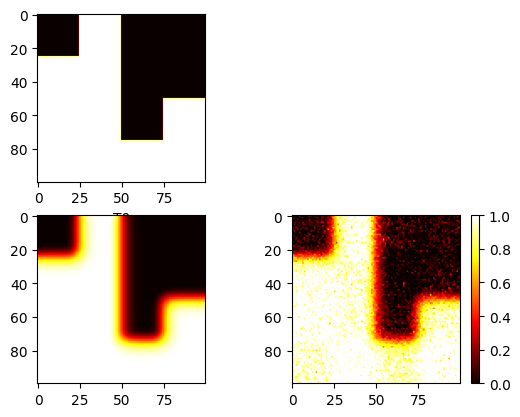

In [32]:
sample = dataset[0]
visual_test_model(trained_model, sample[0],sample[1])

In the top : initial temperature map \\
In the bottom left : modelisation of the diffusion (ground truth) \\
In the bottom right : prediction of the neural network \\
 \\
We can see the model is performing well. With 20 epoch and a hidden size of 2000 in fact we cannot distinguish the prediction from the ground truth. \\
Nonetheless the result is not perfect because if we apply the model on a T0 divided in square but randomly placed (T0blockMap**V2**) we still see the grid use for generating the training samples (all of them comes from T0blockMap) the bias of the training set is reproduced :     



In [49]:
T0 = T0blocksMapV2(100,100)
T1 = diffuse(T0, iterations=10, coef_diff=0.003, dt=0.01, dx=0.01)

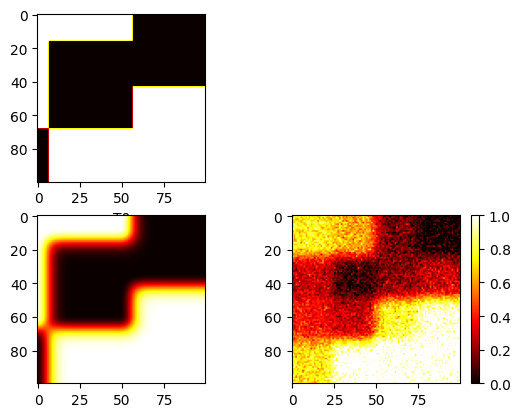

In [50]:
visual_test_model(trained_model, torch.Tensor(T0),torch.Tensor(T1))

In fact we will almost never use the function T0blocksMap but instead I tend to train the models on a mix of T0blocksMapV2 and T0sinusMap, you can use generate_data2 in order to do so. This allow the model to be train on sharp edges and smooth edges as well. \\
After that I designed an other function that generate T0 matrix in order to test model on sharp and smooth edges at once. I also created a test function "MMSE" that compute the mean of the loss function MSE of a pannel of these matrix. This will serve as my metric to quantizize the quality of my models.

In [53]:
#from heat_diffusion_simul.py :
def T0testMap(nx,ny):
    """
    Create a numpy.array of size ny,nx composed of values between 0 and 1.
    the creation of the array is based on T0sinusMap and T0blocksMapV2
    the numpy array will consist of randomly generated blocks of random sizes,
    each blocks composed either of data from a matrix T0sinusMap or T0blocksMapV2

    This function is used to make an ultimate test on trained models
    to see if they can perform well on sharp and smooth T0 altogether
    """
    T0_blocks = T0blocksMapV2(nx,ny)
    T0_sinus = T0sinusMap(nx,ny)

    mask = T0blocksMapV2(nx,ny)
    negatif_mask = np.ones((nx,ny))-mask
    #blocks where value = 0 will be replaced by T0_blocks and where value = 1 by T0_sinus

    return T0_blocks*mask + T0_sinus*negatif_mask

In [54]:
generate_data(300, T0testMap, iters=[10], coef_diffusion=0.003)

100%|██████████| 300/300 [00:44<00:00,  6.80it/s]


In [51]:
#from test_models.py :
def MMSE(trained_model, iteration_no, coef_diff=0.003, batch_size=50):
    """
    :param trained_model:
    :param iteration_no:
    :param coef_diff:
    :param batch_size:
    :return:
    """
    trained_model.eval()
    with torch.no_grad():
        in_folder = f"data/{str(coef_diff).replace('.','_')}/T0testMap/iteration_no0"
        out_folder = f"data/{str(coef_diff).replace('.','_')}/T0testMap/iteration_no{iteration_no}"
        dataset_test = HeatDiffusion(in_folder, out_folder, transform=transforms.ToTensor())
        dataloader = DataLoader(dataset=dataset_test, batch_size=batch_size)
        error = 0.0
        for batch in dataloader:
            prediction = trained_model(batch[0].to(device))
            ground_truth = batch[1].to(device)
            for i in range(batch_size):
                error += float(torch.nn.MSELoss()(prediction[i],ground_truth[i]))
    return error/len(dataset_test)


In [55]:
MMSE(trained_model, 10)

0.04472421814066668